In [54]:
from ast import literal_eval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline
pd.options.display.max_rows = 999

In [2]:
def clean(x):
    return literal_eval(x)

In [3]:
accre_jobs = pd.read_csv('../data/accre_jobs_cleaned.csv', converters={'nodelist': clean})

# Jason --
    Question: 2   CMS Frequency of failure on particular nodes - user names: "cmslocal" and "cmspilot"

The CMS collaboration has an automated job submission system that runs jobs as "cmslocal" and "cmspilot". For these two users, jobs have internal system tests that will terminate their jobs early after approximately 30 minutes. Do any of their jobs that ended in under an hour also cluster on specific compute nodes, suggesting possbily unreliable systems? Check both “production” and “nogpfs” partitions. Look for commonly failing nodes and compare with other failed jobs.

In [55]:
plt.style.use('dark_background')
pio.templates.default = "plotly_dark"

In [5]:
cms_jobs_df = accre_jobs[(accre_jobs['user'] == "cmslocal") | (accre_jobs['user'] == "cmspilot")]

In [6]:
total_jobs = cms_jobs_df.shape[0]

In [7]:
cms_jobs_df['failure'] = np.where(cms_jobs_df['exitcode'] == "0:0", 0, 1)

<ipython-input-7-ee7b4d49ef10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cms_jobs_df['failure'] = np.where(cms_jobs_df['exitcode'] == "0:0", 0, 1)


In [8]:
cms_jobs_failed_df = cms_jobs_df[cms_jobs_df['failure'] == 1]

In [9]:
failures = cms_jobs_failed_df.shape[0]

In [10]:
failures / total_jobs * 100

0.027491310355378974

In [11]:
cms_jobs_df[cms_jobs_df['used_total_seconds'] < 1920].sort_values('used_total_seconds', ascending=False)

,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,state,nodelist,req_total_seconds,used_total_seconds,reqmem_mc,usedmem_mc,failure
1282393,19199513,cms,cmslocal,5000Mn,2236.99M,2-00:00:00,00:31:59,1,1,production,0:0,COMPLETED,[cn1395],172800,1919,5000.000,2236.9900,0
1282376,19199489,cms,cmslocal,5000Mn,1841.12M,2-00:00:00,00:31:59,1,1,production,0:0,COMPLETED,[cn1398],172800,1919,5000.000,1841.1200,0
1282379,19199492,cms,cmslocal,5000Mn,2256.19M,2-00:00:00,00:31:59,1,1,production,0:0,COMPLETED,[cn1395],172800,1919,5000.000,2256.1900,0
3575042,23882247,cms,cmslocal,28000Mn,7668.51M,2-00:00:00,00:31:59,1,4,production,0:0,COMPLETED,[cn355],172800,1919,7000.000,1917.1275,0
3726165,24167068,cms,cmslocal,28000Mn,7482.70M,2-00:00:00,00:31:59,1,4,production,0:0,COMPLETED,[cn1397],172800,1919,7000.000,1870.6750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649685,17996040,cms,cmspilot,21875Mn,0,2-00:00:00,00:00:00,1,8,nogpfs,0:0,COMPLETED,[ng1003],172800,0,2734.375,0.0000,0
748951,18104789,cms,cmspilot,21875Mn,0,2-00:00:00,00:00:00,1,8,nogpfs,0:0,COMPLETED,[ng909],172800,0,2734.375,0.0000,0
748950,18104788,cms,cmspilot,21880Mn,0,2-00:00:00,00:00:00,1,8,nogpfs,0:0,COMPLETED,[ng914],172800,0,2735.000,0.0000,0
748949,18104787,cms,cmspilot,21875Mn,0,2-00:00:00,00:00:00,1,8,nogpfs,0:0,COMPLETED,[ng909],172800,0,2734.375,0.0000,0


In [12]:
cms_jobs_df['early_exit'] = np.where(cms_jobs_df['used_total_seconds'] < 1920, 1, 0)
cms_jobs_df['nodelist'] = cms_jobs_df['nodelist'].str[0]

<ipython-input-12-4207b4a34b97>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cms_jobs_df['early_exit'] = np.where(cms_jobs_df['used_total_seconds'] < 1920, 1, 0)
<ipython-input-12-4207b4a34b97>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cms_jobs_df['nodelist'] = cms_jobs_df['nodelist'].str[0]


In [13]:
early_exits_df = cms_jobs_df[cms_jobs_df['early_exit'] == 1]

In [14]:
early_exits = early_exits_df.shape[0]

In [15]:
early_exits

481093

In [16]:
early_exits / total_jobs * 100

57.50381292521885

In [17]:
node_early_exists = early_exits_df['nodelist'].value_counts()

In [18]:
node_early_exists

ng518           19346
ng1078           6380
ng1112           6164
ng1040           5673
ng1027           5639
ng1003           5619
ng507            5395
ng1067           5346
ng909            5158
ng205            4686
ng502            4614
ng688            4576
ng1063           4551
ng1020           4544
ng514            4449
ng678            4362
ng915            4360
ng1036           4322
ng1080           4319
ng1014           4254
ng1061           4180
ng734            4121
ng1039           4012
ng733            3984
ng512            3596
ng1068           3475
ng739            3454
ng1079           3163
ng729            2539
ng1033           2505
ng732            2311
ng1010           2183
ng505            2114
ng1004           2031
ng1097           1900
ng1064           1627
cn1548           1505
ng1017           1471
ng1069           1434
ng735            1340
ng1028           1287
cn1321           1274
ng1076           1272
ng1019           1249
cn1341           1228
ng1071    

In [19]:
node_jobs = cms_jobs_df['nodelist'].value_counts()

In [20]:
node_partition = cms_jobs_df[['nodelist', 'partition']].drop_duplicates().set_index('nodelist')

In [21]:
node_jobs_df = pd.concat([node_early_exists, node_jobs, node_partition], axis=1)

In [22]:
node_jobs_df

,nodelist,nodelist,partition
ng518,19346.0,19526,nogpfs
ng1078,6380.0,6542,nogpfs
ng1112,6164.0,6333,nogpfs
ng1040,5673.0,5854,nogpfs
ng1027,5639.0,5805,nogpfs
ng1003,5619.0,5801,nogpfs
ng507,5395.0,5566,nogpfs
ng1067,5346.0,5515,nogpfs
ng909,5158.0,5316,nogpfs
ng205,4686.0,4869,nogpfs


In [23]:
node_jobs_df.columns = ['early_exits', 'jobs', 'partition']

In [24]:
node_jobs_df['failure_percent'] = node_jobs_df['early_exits'] / node_jobs_df['jobs'] * 100

In [25]:
node_jobs_df['failure_percent'].describe()

count    818.000000
mean      50.708806
std       17.515431
min       14.285714
25%       39.908123
50%       45.521436
75%       53.057066
max      100.000000
Name: failure_percent, dtype: float64

In [26]:
high_failure_nodes = node_jobs_df[node_jobs_df['failure_percent'] > 53.057066].sort_values('failure_percent', ascending=False)

# Next Steps
- GO back and map high failure_nodes into the cms_jobs list and all the jobs and see if it dispropoiately fails.
- Map out failures by partition
- Map out failure clusters by order to job execution by order of job id

In [27]:
high_failure_nodes

,early_exits,jobs,partition,failure_percent
gpu0020,209.0,209,pascal,100.000000
gpu0032,31.0,31,pascal,100.000000
gpu0019,12.0,12,pascal,100.000000
gpu0026,15.0,15,pascal,100.000000
gpu0031,19.0,19,pascal,100.000000
gpu0015,20.0,20,pascal,100.000000
gpu0034,21.0,21,pascal,100.000000
gpu0014,23.0,23,pascal,100.000000
gpu0018,26.0,26,pascal,100.000000
gpu0021,26.0,26,pascal,100.000000


In [28]:
partition_failures = high_failure_nodes.groupby('partition').agg({'early_exits':['count']})

# upper quartile failures by partition

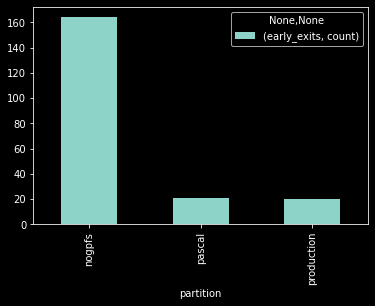

In [29]:
partition_failures.plot(kind='bar');

In [30]:
overall_partitions = node_jobs_df.groupby('partition').agg({'early_exits': 'sum', 'jobs': 'sum'})

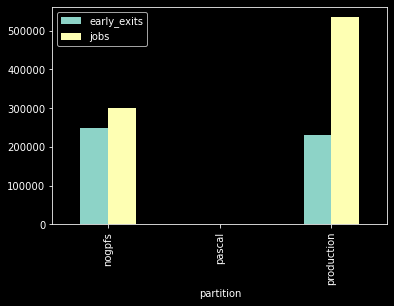

In [31]:
overall_partitions.plot(kind='bar');

In [32]:
cms_jobs_df

,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,state,nodelist,req_total_seconds,used_total_seconds,reqmem_mc,usedmem_mc,failure,early_exit
2119,17032244,cms,cmspilot,28000Mn,8320.07M,2-00:00:00,1-23:31:46,1,4,production,0:0,COMPLETED,cn1205,172800,171106,7000.000,2080.0175,0,0
2120,17032568,cms,cmspilot,28000Mn,11954.84M,2-00:00:00,1-23:33:13,1,4,production,0:0,COMPLETED,cn1492,172800,171193,7000.000,2988.7100,0,0
2121,17032569,cms,cmspilot,28000Mn,10498.84M,2-00:00:00,1-23:36:36,1,4,production,0:0,COMPLETED,cn1497,172800,171396,7000.000,2624.7100,0,0
2122,17032916,cms,cmspilot,21875Mn,11728.02M,2-00:00:00,1-23:27:55,1,8,nogpfs,0:0,COMPLETED,ng1037,172800,170875,2734.375,1466.0025,0,0
2123,17032920,cms,cmspilot,94451Mn,20659.08M,2-00:00:00,1-23:16:04,1,8,nogpfs,0:0,COMPLETED,ng691,172800,170164,11806.375,2582.3850,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729898,24173154,cms,cmspilot,28000Mn,0,2-00:00:00,00:06:41,1,4,production,0:0,RUNNING,cn461,172800,401,7000.000,0.0000,0,1
3729899,24173155,cms,cmspilot,28000Mn,0,2-00:00:00,00:04:04,1,4,production,0:0,RUNNING,cn1516,172800,244,7000.000,0.0000,0,1
3729900,24173156,cms,cmspilot,28000Mn,0,2-00:00:00,00:04:04,1,4,production,0:0,RUNNING,cn1524,172800,244,7000.000,0.0000,0,1
3729901,24173158,cms,cmspilot,28000Mn,0,2-00:00:00,00:04:04,1,4,production,0:0,RUNNING,cn1532,172800,244,7000.000,0.0000,0,1


In [33]:
import math

def index_marks(nrows, chunk_size):
    return range(chunk_size, math.ceil(nrows / chunk_size) * chunk_size, chunk_size)

In [34]:
def split(dfm, chunk_size):
    indices = index_marks(dfm.shape[0], chunk_size)
    return np.split(dfm, indices)

In [35]:
chunked = []

In [36]:
chunks = split(cms_jobs_df, 10000)
for idx, chunk in enumerate(chunks):
    chunked.append(chunk.groupby('partition').agg({'early_exit':sum, 'jobid':'count'}).assign(chunk=idx))

In [37]:
chunked

[            early_exit  jobid  chunk
 partition                           
 nogpfs            3522   4225      0
 production         493   5775      0,
             early_exit  jobid  chunk
 partition                           
 nogpfs            4314   4928      1
 production         714   5072      1,
             early_exit  jobid  chunk
 partition                           
 nogpfs            4419   4874      2
 production         654   5126      2,
             early_exit  jobid  chunk
 partition                           
 nogpfs            4435   5046      3
 production         630   4954      3,
             early_exit  jobid  chunk
 partition                           
 nogpfs            6738   7276      4
 production         827   2724      4,
             early_exit  jobid  chunk
 partition                           
 nogpfs            4313   4976      5
 production         410   5024      5,
             early_exit  jobid  chunk
 partition                           
 nogpf

In [38]:
failures_by_chunk = pd.concat(chunked)

In [39]:
failures_by_chunk = failures_by_chunk.reset_index()

In [40]:
failures_by_chunk

,partition,early_exit,jobid,chunk
0,nogpfs,3522,4225,0
1,production,493,5775,0
2,nogpfs,4314,4928,1
3,production,714,5072,1
4,nogpfs,4419,4874,2
5,production,654,5126,2
6,nogpfs,4435,5046,3
7,production,630,4954,3
8,nogpfs,6738,7276,4
9,production,827,2724,4


In [41]:
failures_by_chunk.columns = ['partition', 'failed', 'total', 'chunk']

In [47]:
node_jobs_df_with_nodelist = node_jobs_df.reset_index()

In [51]:
node_jobs_df_with_nodelist.columns = ['node', 'early_exits', 'jobs', 'partition', 'failure_percent']

In [56]:
px.treemap(node_jobs_df_with_nodelist, 
           path=[
               px.Constant('ACCRE'), 
               'partition', 
               'node'
           ], 
           values='jobs', 
           color='failure_percent')

Index(['ng518', 'ng1078', 'ng1112', 'ng1040', 'ng1027', 'ng1003', 'ng507',
       'ng1067', 'ng909', 'ng205',
       ...
       'cn1410', 'cn1419', 'ng225', 'cn1411', 'cn1401', 'cn1404', 'cn1406',
       'cn1403', 'cn1415', 'cn1409'],
      dtype='object', length=823)